<a href="https://colab.research.google.com/github/NasserHeydari/SFL-Interview-Project/blob/master/Activity_Recognition_SFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Python notebook prepared for activity recognition from data collected via a single chest-mounted accelerometer**

# Nasser Heydari
 

# **Introduction** 

Human activity recognition (HAR) is the problem of classifying sequences of accelerometer data recorded by a sensor (e.g. chest-mounted accelerometers or smart phones) into known well-defined movements. It is a challenging problem given the large number of observations produced each second, the temporal nature of the observations, and the lack of a clear way to relate accelerometer data to known movements.

This notenook demonestrates a frame work that can be followed to identify/predict an activity (Working at Computer, Standing Up, Walking and Going Up/Downstairs, Standing, Walking, Going Up/Down Stairs, Walking and Talking with Someone, Talking while Standing) from the accelerometer data containnig information for three directions. The Z-axis represents the axis concordant to the direction of movement and the plane defined by the X and Y axis lies on the body of the person.

This notebook has been organized as follows:

**A.** We perform an exploratory data analysis to analyze the available data and summarize their main characteristics.

**B.** We introduce a framework for removing outliers from the data.  

**C.** We construct features from existing data to train machine learning models.

**D.** We train several algorithms and evaluate their performance.

**E.** A conclusion including some recommendations for future work will end this notebook.




# Let's first import some libraries and  load our dataset before performing any analysis

In [1]:
import io
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import files
uploaded = files.upload()

Here is the list of activitis and their corresponding labels in the dataset:

In [0]:
activities =['Working at Computer','Standing Up, Walking and Going Up/Downstairs','Standing','Walking','Going Up/Down Stairs','Walking and Talking with Someone','Talking while Standing']

Labels = {0: 'Unkown',          # Unkown activity is probably when the accelerometer is off
          1:'Working at Computer',
          2:'Standing Up, Walking and Going Up/Downstairs',
          3:'Standing',
          4:'Walking',
          5:'Going Up/Down Stairs',
          6:'Walking and Talking with Someone',
          7:'Talking while Standing'}

In [0]:
df = pd.DataFrame()
i = 1
for file in uploaded.keys():
  data = pd.read_csv(io.BytesIO(uploaded[file]),header=None,names = ['timestamp','x_acc','y_acc','z_acc','activity'])
  data['acc_mag'] = (data['x_acc'] **2 + data['y_acc'] **2 + data['z_acc'] **2)**0.5            # I added a extra feature here called acc_mag which shows the magnitude of the resultant accelaration 
  data['timestamp'] =  np.arange(len(data))                                                     # this is to keep track of timestamps
  data['user'] = i                                                                              # this is to keep track of user ids
  i += 1
  df = df.append(data)

In [0]:
df = df.replace({"activity": Labels})

In [7]:
df.head()

,timestamp,x_acc,y_acc,z_acc,activity,acc_mag,user
0,0,1502,2215,2153,Working at Computer,3434.768988,1
1,1,1667,2072,2047,Working at Computer,3355.932359,1
2,2,1611,1957,1906,Working at Computer,3171.435952,1
3,3,1601,1939,1831,Working at Computer,3110.543843,1
4,4,1643,1965,1879,Working at Computer,3176.683018,1


# A. Exploratory Data Analysis

### A.1. Checking for duplicates

In [8]:
print('Number of duplicates in our dataset: {}'.format(sum(df.duplicated())))

Number of duplicates in our dataset: 0


### A. 2. Checking for NaN/null values

In [9]:
print('We have {} NaN/Null values in in our dataset'.format(df.isnull().values.sum()))


We have 0 NaN/Null values in in our dataset


### A. 3. Checking data provided for each user/subject



From the figure below it is clear that all the users/subjects perform all the seven activities assigned to them. However, one can notice that the users' behavior are not the same and the duration of activities performed by each user is not balanced. For example, it is clear that users 1, 5, 7, and 9 spend more time on "Talking while standing". On the other hand, users 11, 12, 14, and 15 spend more time on "Working at computer" and less time on Talking while standing". **The conclusion here is that** the duration of activities for each user is not balanced and the users behavior are different from one another.


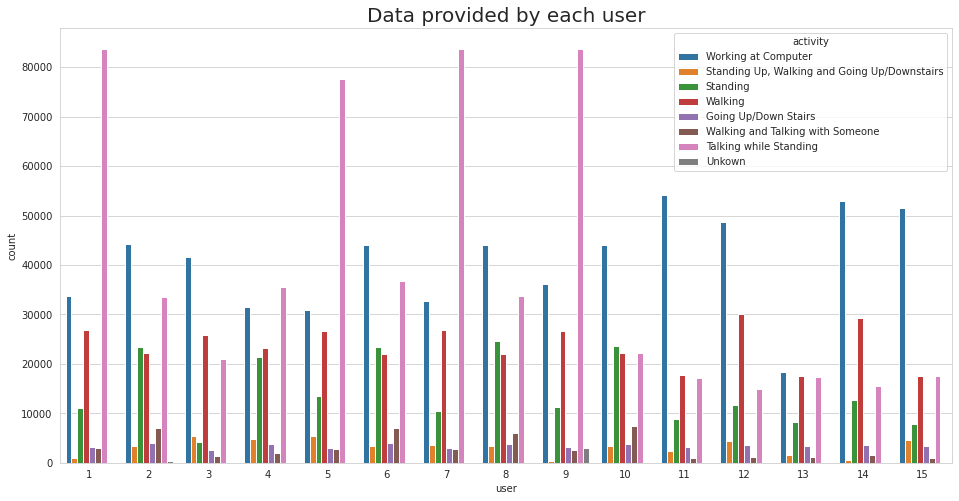

In [10]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='user',hue='activity', data = df)
plt.show()

### A. 4. Checking number of data points per activity



The below figure better shows that the number of activities in our dataset is not balance. One can notice that "Talking while standing" and "Working at Computer" are the dominant activities in our dataset. 

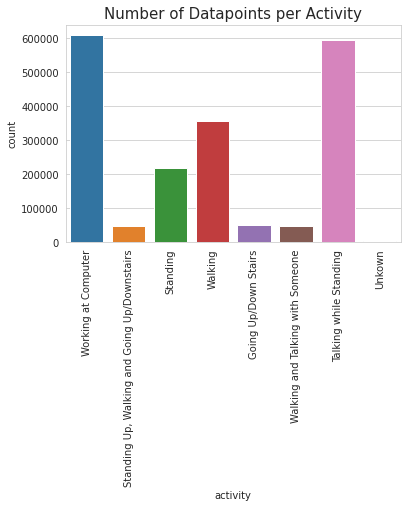

In [11]:
plt.title('Number of Datapoints per Activity', fontsize=15)
sns.countplot(df.activity)
plt.xticks(rotation=90)
plt.show()

### A. 5. Checking the underlying distibution of the activities in the dataset.




Intuitively we expect that the distribution of the accelometer values be different for stationary activities such as "Working at Computer", "Standing", and "Talking while standing" from the activities which require movement, such as "Walking" and "Going Up/Down Stairs". However, from the figure below it is not clear whether there is a well-defined threshold that can separate stationary activies from moving activities. This probably relates to the users' behavior. For example, it is possible that when they were suppose to "Work at Computer" they were also moving around.

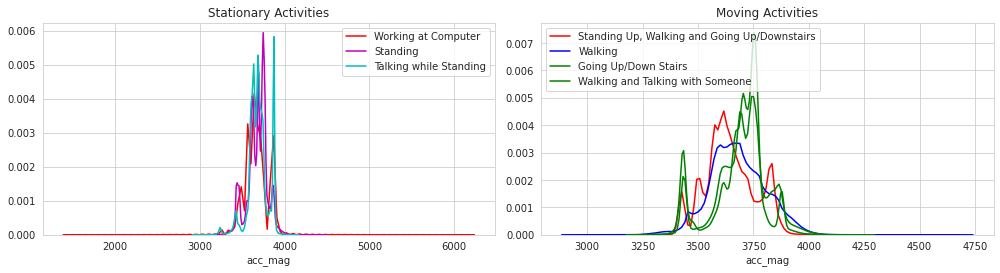

In [12]:
df1 = df[df['activity']=='Working at Computer']       # Statinary Activity
df2 = df[df['activity']=='Standing']                  # Statinary Activity
df3 = df[df['activity']=='Talking while Standing']    # Statinary Activity
df4 = df[df['activity']=='Standing Up, Walking and Going Up/Downstairs']  # Statinary Activity
df5 = df[df['activity']=='Walking']                   # Moving Activity
df6 = df[df['activity']=='Going Up/Down Stairs']       # Moving Activity
df7 = df[df['activity']=='Walking and Talking with Someone']  # Moving Activity

plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.title('Stationary Activities')
sns.distplot(df1['acc_mag'],color = 'r',hist = False, label = 'Working at Computer')
sns.distplot(df2['acc_mag'],color = 'm',hist = False,label = 'Standing')
sns.distplot(df3['acc_mag'],color = 'c',hist = False, label = 'Talking while Standing')
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df4['acc_mag'],color = 'red',hist = False, label = 'Standing Up, Walking and Going Up/Downstairs')
sns.distplot(df5['acc_mag'],color = 'blue',hist = False,label = 'Walking')
sns.distplot(df6['acc_mag'],color = 'green',hist = False, label = 'Going Up/Down Stairs')
sns.distplot(df7['acc_mag'],color = 'green',hist = False, label = 'Walking and Talking with Someone')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

When we look at a boxplot of the activities for all users, again we can better see that there is no clear threshold for the accelaration magnitude that can separate the activites from one another. 

In [0]:
def plotBOX(data,title):
  plt.figure(figsize=(5,5))
  sns.boxplot(x='activity', y='acc_mag',data=data, showfliers=False, saturation=1)
  plt.ylabel('Acceleration Magnitude')
  plt.title(title)
  plt.xticks(rotation=90)
  plt.show()

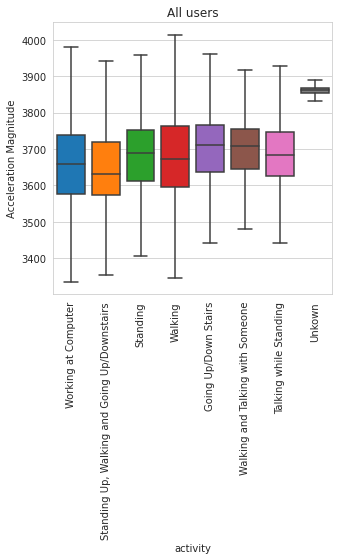

In [14]:
plotBOX(df, 'All users')

If we build the box plot of the activities for each user and then compare them with each other, we can clearly see that, as mentioned earlier, the users' behavior are different from one another and still there is no clear threshold for each user that can separarte the stationary activities from the moving activities. As an example regarding the difference in users' behavior, it looks like that higher accelarations were recorded by user 2 while he/she was suppose to work at a computer compared with the user 10. 

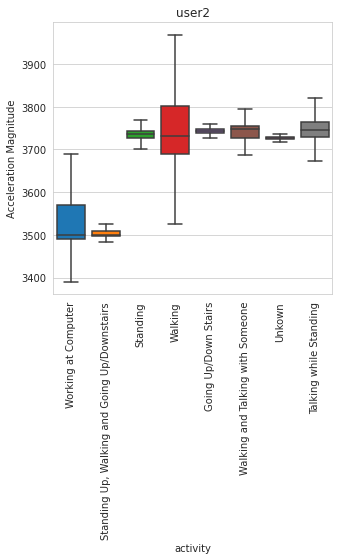

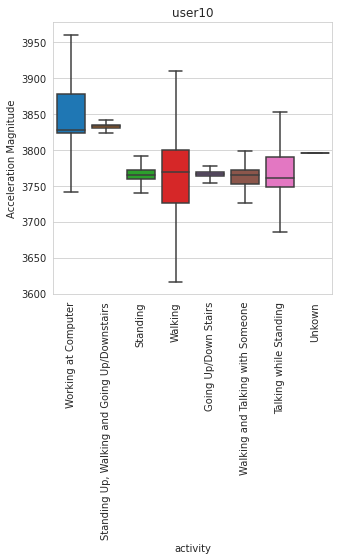

In [15]:
for i in [2,10]:
  data = df[df['user']== i]
  plotBOX(data, 'user'+str(i))


### A. 6. Examining the accelerometer data for each activity reported by each user.




Interesting observations were made after investigating the scatter plots of the activities for each user. For example, if we look at the data recorded by user 5, we can see some very large movement in the beginning or between some activities such as "Standing" and "Working at Computer". For the same user, if we look at the accelerometer data reorded for "Walking", we can see that for some time in the beginning there are very small, if any movements. These kind of data points may be outlier or unusual behavior that could be removed. Therefore, it is necessary to filter the data to remove periods that would be otherwise mislabeled. We present the outlier removal framework in **Section B**. 

In [0]:
def plot_xyz(time, x_accel,y_accel,z_accel,ylabel,title):
    plt.figure(figsize=(9,5))
    xp = plt.scatter(time, x_accel,s=0.2,c='r')
    plt.title(title)
    yp = plt.scatter(time, y_accel,s=0.2,c='b')
    zp = plt.scatter(time, z_accel,s=0.2, c='g')
    plt.legend((xp, yp, zp), ('X direction', 'Y direction', 'Z direction'))
               
    plt.xlabel('time')
    plt.ylabel(ylabel)
    plt.show();

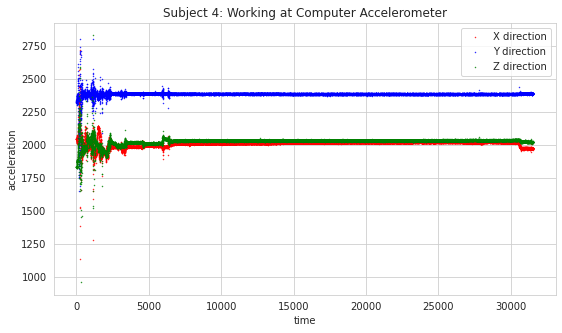

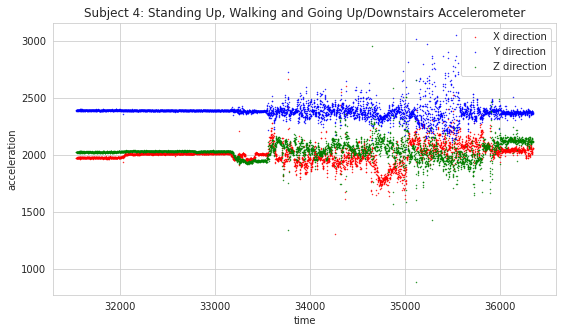

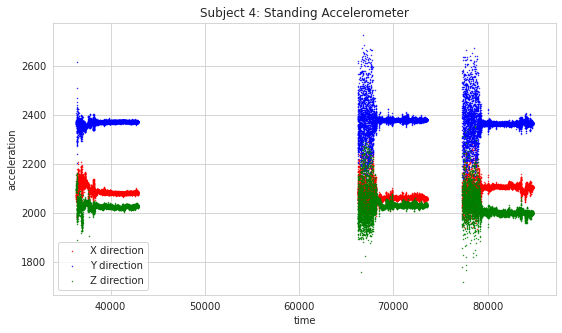

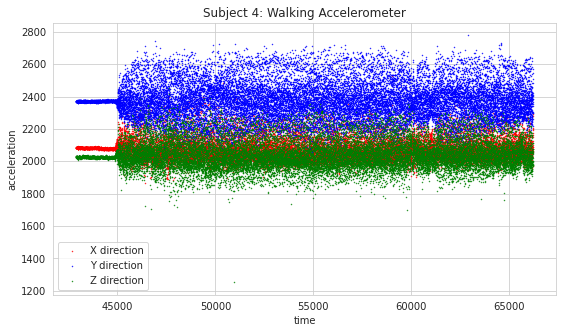

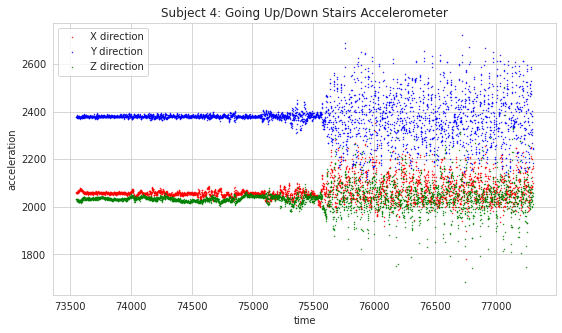

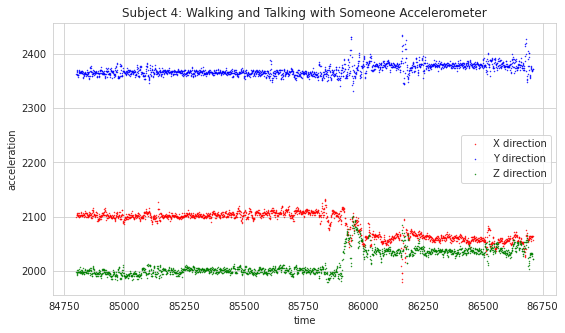

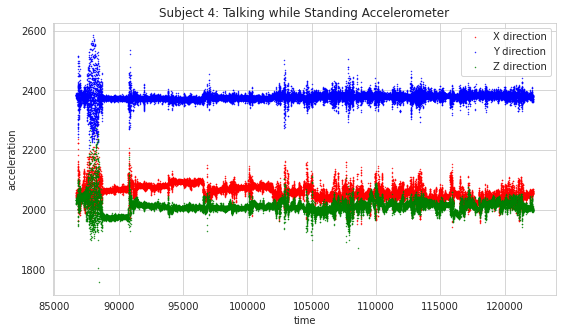

In [17]:
activities =['Working at Computer','Standing Up, Walking and Going Up/Downstairs','Standing','Walking','Going Up/Down Stairs','Walking and Talking with Someone','Talking while Standing']
for subject in range(4,5):
    for activity in activities:
        if activity != 'Unkown':
          current_df = df[(df['user']==subject)&(df['activity']==activity)]
          title = "Subject "+str(subject) + ": "+ activity + " Accelerometer"
          ylabel="acceleration"
          plot_xyz(current_df.timestamp,current_df.x_acc,current_df.y_acc,current_df.z_acc,ylabel,title)



# B. Removing Outliers (bad time periods)

In order to remove very large or very small movements that occur within short period of times, I divided the raw data into one-second windows, each with 52 observations (at 52 Hz). I labeled each 52 consecutive observations for each user with a sample number (dropping any remainder). I then calculated std within each group with the same sample number and then employed the interquartile rule approach to find bad time windows (smaple numbers). I followed this outlier detection method separately for each user because as discussed earlier it seems that the users' behavior were different from one another. 

In [18]:
df_SN = pd.DataFrame()   # dataframe with sample numbers
last_sample = 0
windowsize = 52
for subject in range(1,16):
    temp_df = df[df['user']==subject].sort_values(by=['timestamp'])
    temp_df['sample_num']=-1
    remainder=len(temp_df) % windowsize
    temp_df=temp_df[:-remainder]
    num_samples=int(len(temp_df)/windowsize)  
    row_counter=0
    for j in range(0,num_samples):   
        temp_df['sample_num'].iloc[row_counter:row_counter+windowsize]=last_sample+j # label samples
        row_counter=row_counter+windowsize
    last_sample+=num_samples # label the samples consecutively across activities
    df_SN = df_SN.append(temp_df, ignore_index=True) 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


The total number of data points after assigning sample number decreased only by << 1%

In [19]:
len(df_SN)/len(df)

0.9997654258455049

Now we calculate the std after grouping by 'activity','user', and 'sample_num'. This ensures that we do not mix up activities and users.

In [0]:
deviation = df_SN.groupby(['activity','user','sample_num']).std()
deviation.reset_index(inplace=True) 
deviation = deviation.sort_values(by=['sample_num'])

In [21]:
deviation.head()

,activity,user,sample_num,timestamp,x_acc,y_acc,z_acc,acc_mag
25458,Working at Computer,1,0,15.154757,39.374943,115.800491,71.632504,77.950997
25459,Working at Computer,1,1,15.154757,62.728565,102.253242,78.921912,76.738697
25460,Working at Computer,1,2,15.154757,180.559290,74.763559,161.379436,143.230002
25461,Working at Computer,1,3,15.154757,132.926759,73.830357,131.714097,90.123066
25462,Working at Computer,1,4,15.154757,70.908572,50.952319,97.394432,54.106975


Now we drop samples that do not meet the threshold tests based on the interquartile range. We use the accelaration magnitude for the filtering purpose. Note that we take the "Walking" data, when we analyze each user, to better detect outliers in other activities.

In [0]:
def find_bad_samples(temp,activity,samples_to_drop,operator,threshold):
    mask =(temp.activity == activity) & operator(temp.acc_mag, threshold)
    return samples_to_drop.extend(list(temp.sample_num[mask]))

In [23]:
activities

['Unkown',
 'Working at Computer',
 'Standing Up, Walking and Going Up/Downstairs',
 'Standing',
 'Walking',
 'Going Up/Down Stairs',
 'Walking and Talking with Someone',
 'Talking while Standing']

In [0]:
samples_to_drop = []
for subject in range(1,16):
  user_df = deviation[deviation['user']==subject]
  Q1s = {}
  Q3s = {}
  IQRs = {}
  stds = {}

  for activity in activities:
    temp_df = user_df[user_df['activity']==activity]
    Q1s[activity] = temp_df.quantile(0.25).acc_mag
    Q3s[activity] = temp_df.quantile(0.75).acc_mag
    IQRs[activity] = Q3s[activity] - Q1s[activity]
    stds[activity] = user_df[user_df['activity']==activity].std().acc_mag

  for activity in activities:
    if (activity == 'Walking' or activity == 'Working at Computer' or activity == 'Going Up/Down Stairs' or activity == 'Talking while Standing'):
      find_bad_samples(user_df,activity,samples_to_drop,operator.lt,Q1s[activity]-1.5*IQRs[activity])
      find_bad_samples(user_df,activity,samples_to_drop,operator.gt,Q3s[activity]+1.5*IQRs[activity])

    elif (activity == 'Standing Up, Walking and Going Up/Downstairs' or activity == 'Walking and Talking with Someone' or activity =='Going Up/Down Stairs'):
      find_bad_samples(user_df,activity,samples_to_drop,operator.lt,Q1s[activity]-1.5*IQRs[activity])
      find_bad_samples(user_df,activity,samples_to_drop,operator.gt,Q3s[activity]+1.5*IQRs[activity])
      find_bad_samples(user_df,activity,samples_to_drop,operator.lt,Q1s['Walking']-1.5*IQRs['Walking'])
      find_bad_samples(user_df,activity,samples_to_drop,operator.lt,stds['Walking'])

    elif activity == 'Standing':
      find_bad_samples(user_df,activity,samples_to_drop,operator.gt,Q3s['Walking']+1.5*IQRs['Walking'])
      find_bad_samples(user_df,activity,samples_to_drop,operator.gt,stds['Walking'])
  

We identified that about 18.5 % of the data points are outliers.

In [25]:
len(samples_to_drop)/len(deviation)


0.18509550712940542

In [0]:
clean_data = df_SN[~df_SN.sample_num.isin(samples_to_drop)]

In [27]:
clean_data.head()

,timestamp,x_acc,y_acc,z_acc,activity,acc_mag,user,sample_num
468,468,1962,2374,2125,Working at Computer,3741.783666,1,9
469,469,1961,2380,2127,Working at Computer,3746.204746,1,9
470,470,1953,2386,2135,Working at Computer,3750.390646,1,9
471,471,1953,2381,2137,Working at Computer,3748.351504,1,9
472,472,1965,2380,2127,Working at Computer,3748.300148,1,9




Let's look at "Walking" data for user 4 before and after removing the outlier windows/data points. It seems that we did a good job :)

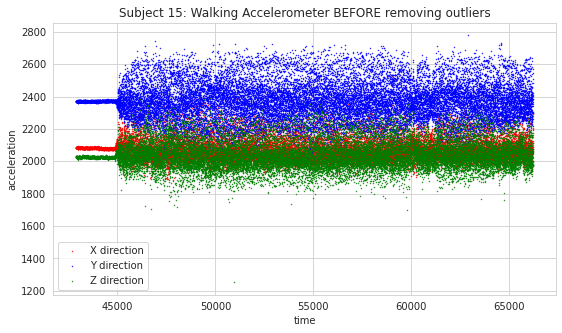

In [28]:
temp_df = df[(df['user']==4)&(df['activity']=='Walking')]
title = "Subject "+str(subject) + ": "+ 'Walking' + " Accelerometer" + " BEFORE removing outliers"
ylabel="acceleration"
plot_xyz(temp_df.timestamp,temp_df.x_acc,temp_df.y_acc,temp_df.z_acc,ylabel,title)

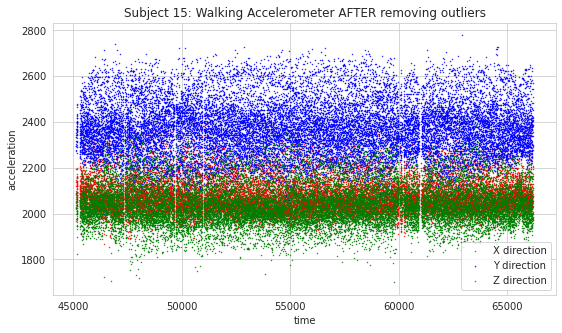

In [29]:
temp_df = clean_data[(clean_data['user']==4)&(clean_data['activity']=='Walking')]
title = "Subject "+str(subject) + ": "+ 'Walking' + " Accelerometer" + " AFTER removing outliers"
ylabel="acceleration"
plot_xyz(temp_df.timestamp,temp_df.x_acc,temp_df.y_acc,temp_df.z_acc,ylabel,title)

However, if we look at the 'Going Up/Down Stairs' data, we see that the  above outlier decetion approach is probably not very helpful because a user (number 8 for example) may not do this task for a long time. See the below figures. **Therefore, one potential future work is to build a more robust outlier detection framework.**

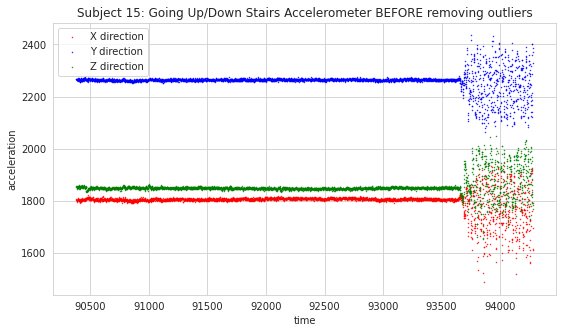

In [30]:
temp_df = df[(df['user']==8)&(df['activity']=='Going Up/Down Stairs')]
title = "Subject "+str(subject) + ": "+ 'Going Up/Down Stairs' + " Accelerometer" + " BEFORE removing outliers"
ylabel="acceleration"
plot_xyz(temp_df.timestamp,temp_df.x_acc,temp_df.y_acc,temp_df.z_acc,ylabel,title)

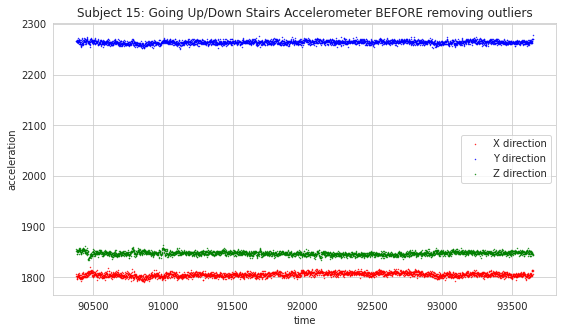

In [31]:
temp_df = clean_data[(clean_data['user']==8)&(clean_data['activity']=='Going Up/Down Stairs')]
title = "Subject "+str(subject) + ": "+ 'Going Up/Down Stairs' + " Accelerometer" + " BEFORE removing outliers"
ylabel="acceleration"
plot_xyz(temp_df.timestamp,temp_df.x_acc,temp_df.y_acc,temp_df.z_acc,ylabel,title)

In [32]:
clean_data.head()

,timestamp,x_acc,y_acc,z_acc,activity,acc_mag,user,sample_num
468,468,1962,2374,2125,Working at Computer,3741.783666,1,9
469,469,1961,2380,2127,Working at Computer,3746.204746,1,9
470,470,1953,2386,2135,Working at Computer,3750.390646,1,9
471,471,1953,2381,2137,Working at Computer,3748.351504,1,9
472,472,1965,2380,2127,Working at Computer,3748.300148,1,9


Looking at the data after removing the outliers, we still see that the number of acticities are not balanced within the dataset. Therefore, it is probabbly a good idea to down sample the activities that are dominant, namely "Working at Computer" and "Talking while Standing".

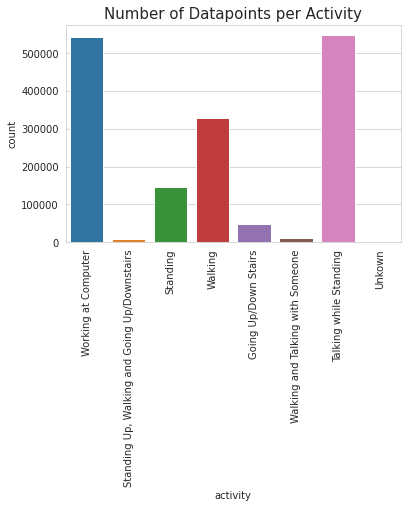

In [33]:
plt.title('Number of Datapoints per Activity', fontsize=15)
sns.countplot(clean_data.activity)
plt.xticks(rotation=90)
plt.show()

Here is a piece of code to randomly downsample 'Talking while Standing' and 'Working at Computer' in our dataset.

In [0]:
down_talking = clean_data[clean_data['activity']=='Talking while Standing'].sample_num.unique()
talking_indices = np.random.choice(len(down_talking), size=len(down_talking)//3, replace=False)

down_computer = clean_data[clean_data['activity']=='Working at Computer'].sample_num.unique()
computer_indices = np.random.choice(len(down_computer), size=len(down_computer)//3, replace=False)

down = list(down_talking[talking_indices]) + list(down_computer[computer_indices])
clean_data_down = clean_data[~clean_data.sample_num.isin(down)]

We also upsample 'Standing Up, Walking and Going Up/Downstairs', 'Walking and Talking with Someone', and 'Going Up/Down Stairs'

In [0]:
temp1 = clean_data_down[clean_data_down['activity']=='Standing Up, Walking and Going Up/Downstairs']
temp2 = clean_data_down[clean_data_down['activity']=='Walking and Talking with Someone']
temp3 = clean_data_down[clean_data_down['activity']=='Going Up/Down Stairs']
clean_data_down_up = pd.concat([clean_data_down,temp1,temp2,temp3],axis=0)
for i in range(1,8):
  clean_data_down_up = pd.concat([clean_data_down_up,temp1,temp2],axis=0)
for i in range(1,2):
  clean_data_down_up = pd.concat([clean_data_down_up,temp3],axis=0)

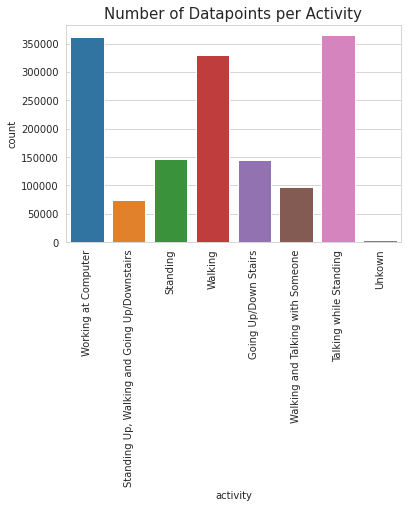

In [36]:
plt.title('Number of Datapoints per Activity', fontsize=15)
sns.countplot(clean_data_down_up.activity)
plt.xticks(rotation=90)
plt.show()

# **C. Feature Generation and Data Preparation** 

let's generate some features before developing any model.

In [0]:
def Range(x):
    return x.max() - x.min()

def interquartile(X):
  return X.quantile(0.75) - X.quantile(0.25)

def rms(X):
  return np.sqrt(np.mean(X**2))


In [0]:
ranges = clean_data_down_up.groupby(['activity','user','sample_num']).apply(Range).add_prefix('range_')
interquartiles_ = clean_data_down_up.groupby(['activity','user','sample_num']).apply(interquartile).add_prefix('interquartile_')
st_devs = clean_data_down_up.groupby(['activity','user','sample_num']).std().add_prefix('std_')
means = clean_data_down_up.groupby(['activity','user','sample_num']).mean().add_prefix('mean_')
rms_ = clean_data_down_up.groupby(['activity','user','sample_num']).apply(rms).add_prefix('rms_')

In [0]:
df_train_test = pd.concat([ranges,interquartiles_,st_devs,means,rms_],axis=1)
df_train_test.reset_index(inplace=True)

In [0]:
Features =['range_timestamp', 'interquartile_timestamp','std_timestamp', 'mean_timestamp', 'rms_timestamp' , 'range_x_acc','range_y_acc', 'range_z_acc', 'range_acc_mag',
           'interquartile_x_acc', 'interquartile_y_acc',  'interquartile_z_acc', 'interquartile_acc_mag', 'std_x_acc', 'std_y_acc', 'std_z_acc', 'std_acc_mag',
           'mean_x_acc', 'mean_y_acc', 'mean_z_acc', 'mean_acc_mag','rms_x_acc', 'rms_y_acc', 'rms_z_acc', 'rms_acc_mag']

In [0]:
df_train_test = df_train_test.dropna()
df_train_test = df_train_test[df_train_test['activity'] != 'Unkown']

In [0]:
train_mask = df_train_test.user <= 11
test_mask = 12  <= df_train_test.user
X_train = df_train_test[Features][train_mask]
X_test = df_train_test[Features][test_mask]
y_train = df_train_test.activity[train_mask]
y_test = df_train_test.activity[test_mask]

Examination of the correlation between the features idicated that several features are highly correlated with each other. Therefore, it is necessary to only keep importatnt features that are less correlate with others. Later, this can help us to avoid over fitting.

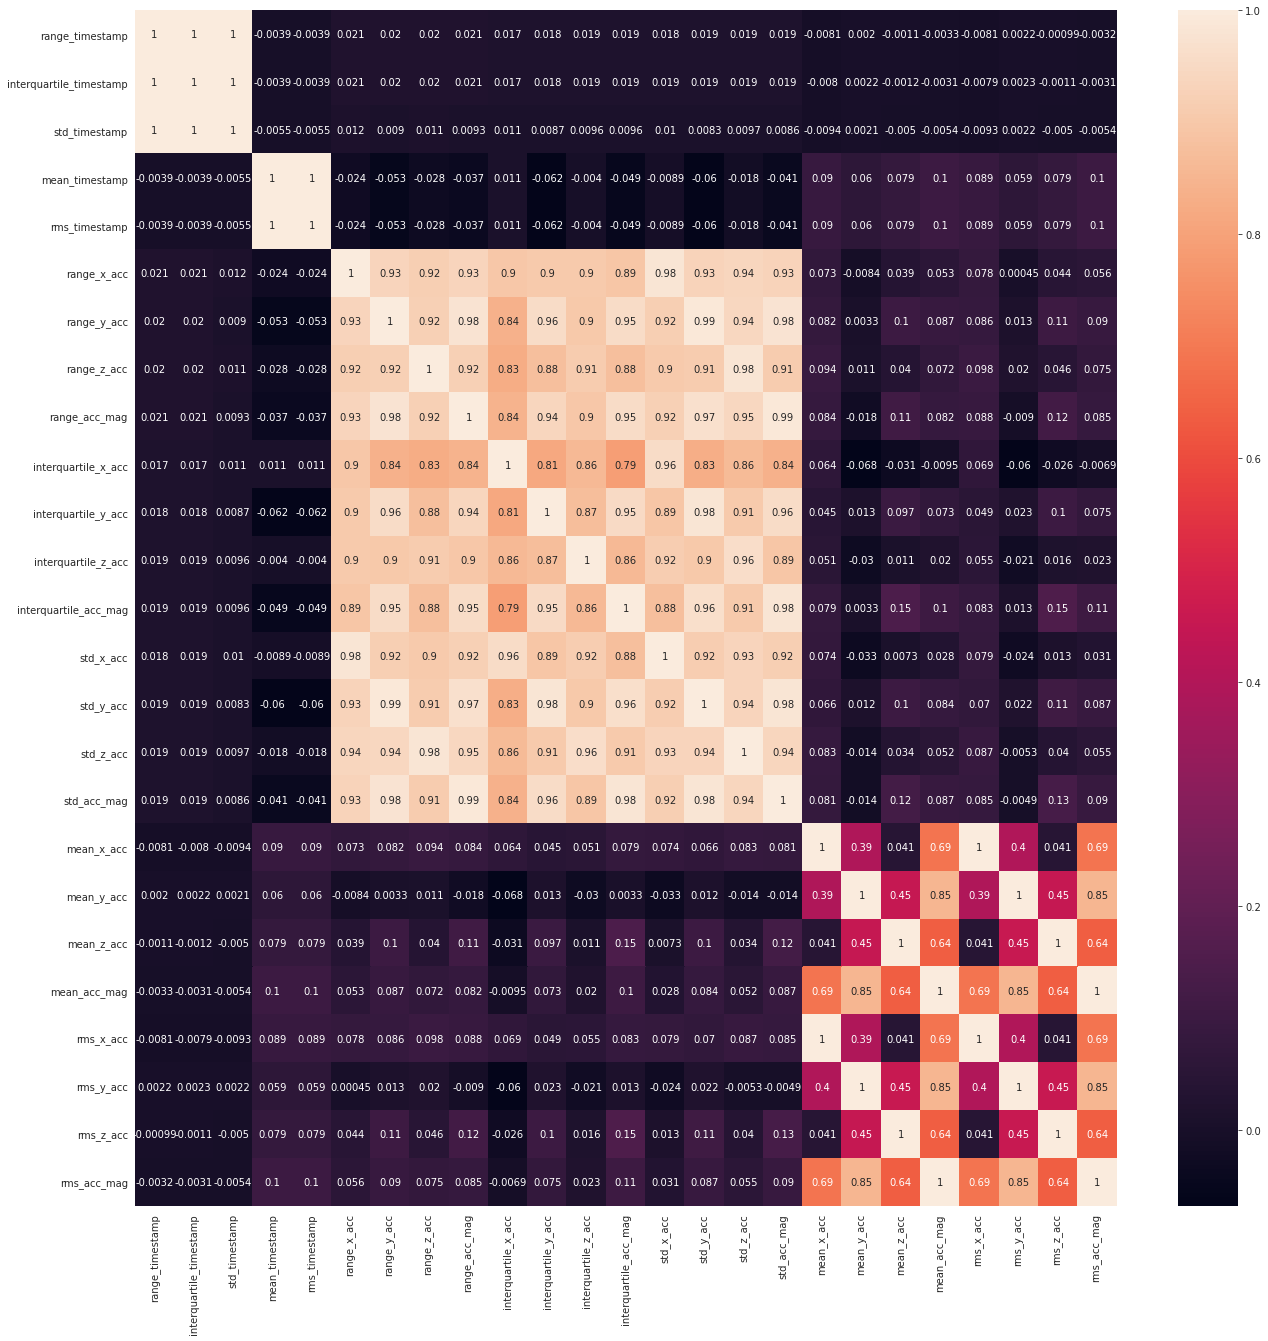

In [43]:
fig, ax = plt.subplots(figsize=(22,22))         # Sample figsize in inches
sns.heatmap(X_train.corr(), annot = True)

In order to determine which features are importatnt we performed random forest analysis. 

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))


R^2 Training Score: 1.00 
OOB Score: 1.00 
R^2 Validation Score: 0.76


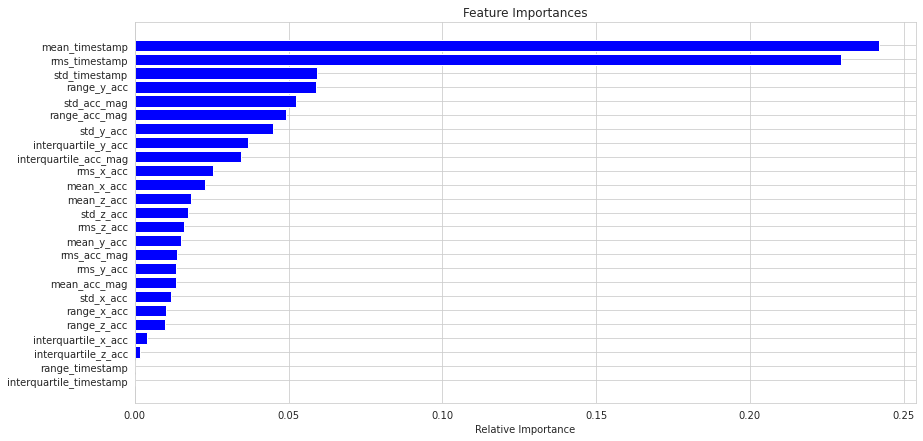

In [45]:
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(14,7))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

After examinig the correlation heatmap and the importance of features suggested by the RAndom Forest analysis, we decided to keep the following featrures:

Important_Features = ['mean_timestamp', 'std_y_acc', 'rms_x_acc', 'rms_y_acc','rms_z_acc', 'interquartile_x_acc']



In [0]:
Important_Features = ['mean_timestamp', 'std_timestamp','std_y_acc', 'rms_x_acc', 'rms_y_acc','rms_z_acc']

In [0]:
X_train = df_train_test[Important_Features][train_mask]
X_test = df_train_test[Important_Features][test_mask]
y_train = df_train_test.activity[train_mask]
y_test = df_train_test.activity[test_mask]

Here is the correlation heat map for the new features

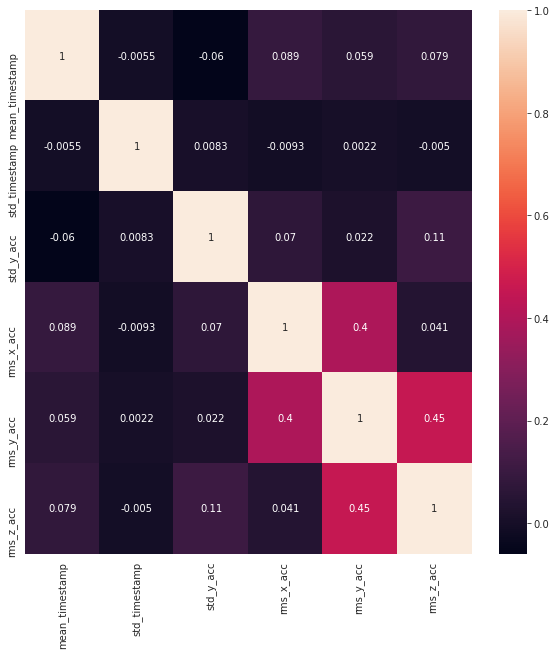

In [48]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(X_train.corr(), annot = True)

We also standardize features by removing the mean and scaling to unit variance:

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# **D. Model Development**

In this section we train and evaluate different classifiers. **Please note that due to time limitation they are not very well tuned!**

In [0]:
from statsmodels.api import add_constant,MNLogit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,accuracy_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB,GaussianNB


##Logistic Regression

In [51]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
y_pred_train = LR.predict(X_train)
y_pred_test = LR.predict(X_test)
print(f'Training F1 score is: {f1_score(y_train,y_pred_train,average="macro"):.3f}')
print(f'Testing F1 score is: {f1_score(y_test,y_pred_test,average="macro"):.3f}')
print('The training accuracy is:',LR.score(X_train, y_train))
print('The test accuracy is:',LR.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training F1 score is: 0.767
Testing F1 score is: 0.500
The training accuracy is: 0.9287125623960066
The test accuracy is: 0.7753414118099634


## KNeighborsClassifier

In [52]:
k_range = list(range(2,10))
weight_options = ["uniform", "distance"]
leaf = [20,30,40]
param_grid = dict(n_neighbors = k_range, weights = weight_options, leaf_size = leaf)
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv = 8, scoring = 'accuracy')
knn_grid.fit(X_train,y_train)

y_pred_train = knn_grid.predict(X_train)
y_pred_test = knn_grid.predict(X_test)
print(f'Training F1 score is: {f1_score(y_train,y_pred_train,average="macro"):.3f}')
print(f'Testing F1 score is: {f1_score(y_test,y_pred_test,average="macro"):.3f}')
print('The training accuracy is:',knn_grid.score(X_train, y_train))
print('The test accuracy is:',knn_grid.score(X_test, y_test))

Training F1 score is: 1.000
Testing F1 score is: 0.473
The training accuracy is: 1.0
The test accuracy is: 0.7041738795922293


## DecisionTreeClassifier

In [53]:
depth = [10,15,20,25,30]
minSamplesSplit = [2,4,6]
param_grid = dict(max_depth = depth, min_samples_split = minSamplesSplit )
DecisionTree = DecisionTreeClassifier()
DT_grid = GridSearchCV(DecisionTree, param_grid, cv = 7, scoring = 'accuracy')
DT_grid.fit(X_train,y_train)

y_pred_train = DT_grid.predict(X_train)
y_pred_test = DT_grid.predict(X_test)
print(f'Training F1 score is: {f1_score(y_train,y_pred_train,average="macro"):.3f}')
print(f'Testing F1 score is: {f1_score(y_test,y_pred_test,average="macro"):.3f}')
print('The training accuracy is:',DT_grid.score(X_train, y_train))
print('The test accuracy is:',DT_grid.score(X_test, y_test))

Training F1 score is: 0.998
Testing F1 score is: 0.698
The training accuracy is: 0.9995840266222962
The test accuracy is: 0.7889978842085016


## BaggingClassifier

In [54]:
maxFeatures = [4,5, 6]
maxSamples = [1,2,3]
estimators = [50,100,150,200]

param_grid = dict(max_features = maxFeatures, max_samples = maxSamples, n_estimators = estimators )
BaggingClassifier_ = BaggingClassifier()
BC_grid = GridSearchCV(BaggingClassifier_, param_grid, cv = 7, scoring = 'accuracy')
BC_grid.fit(X_train,y_train)

y_pred_train = BC_grid.predict(X_train)
y_pred_test = BC_grid.predict(X_test)
print(f'Training F1 score is: {f1_score(y_train,y_pred_train,average="macro"):.3f}')
print(f'Testing F1 score is: {f1_score(y_test,y_pred_test,average="macro"):.3f}')
print('The training accuracy is:',BC_grid.score(X_train, y_train))
print('The test accuracy is:',BC_grid.score(X_test, y_test))

Training F1 score is: 0.352
Testing F1 score is: 0.287
The training accuracy is: 0.7443843594009983
The test accuracy is: 0.6495479899980765


## SVM Classifier

In [55]:
# from sklearn import svm
from sklearn.svm import SVC
clf = SVC(gamma='auto')

Cs = [0.1, 1, 10]
gammas = [0.01, 0.1, 1]
param_grid = dict(C = Cs, gamma = gammas)
SVM_ = svm.SVC(kernel='rbf')
SVM_grid = GridSearchCV(SVM_, param_grid, cv=8)

SVM_grid.fit(X_train,y_train)

y_pred_train = SVM_grid.predict(X_train)
y_pred_test = SVM_grid.predict(X_test)
print(f'Training F1 score is: {f1_score(y_train,y_pred_train,average="macro"):.3f}')
print(f'Testing F1 score is: {f1_score(y_test,y_pred_test,average="macro"):.3f}')
print('The training accuracy is:',SVM_grid.score(X_train, y_train))
print('The test accuracy is:',SVM_grid.score(X_test, y_test))

Training F1 score is: 0.934
Testing F1 score is: 0.596
The training accuracy is: 0.970985856905158
The test accuracy is: 0.8253510290440469


## XGBClassifier

In [56]:

XGB = XGBClassifier()
XGB.fit(X_train, y_train)
y_pred_train = XGB.predict(X_train)
y_pred_test = XGB.predict(X_test)

print(f'Training F1 score is: {f1_score(y_train,y_pred_train,average="macro"):.3f}')
print(f'Testing F1 score is: {f1_score(y_test,y_pred_test,average="macro"):.3f}')
print('The training accuracy is:',XGB.score(X_train, y_train))
print('The test accuracy is:',XGB.score(X_test, y_test))

Training F1 score is: 0.998
Testing F1 score is: 0.795
The training accuracy is: 0.9981801164725458
The test accuracy is: 0.7809194075783804


## GradientBoostingClassifier

In [57]:
n_estimators_= [20, 40, 60]
learning_rate_ = [0.01, 0.1]
max_features_ = 5
max_depth_ = [5, 7, 9]

param_grid = dict(n_estimators = n_estimators_, learning_rate = learning_rate_, max_depth = max_depth_)

gb_clf = GradientBoostingClassifier(max_features = max_features_)
  
gb_clf_grid = GridSearchCV(gb_clf, param_grid, cv = 7, scoring = 'accuracy')
gb_clf_grid.fit(X_train,y_train)

y_pred_train = gb_clf_grid.predict(X_train)
y_pred_test = gb_clf_grid.predict(X_test)
print(f'Training F1 score is: {f1_score(y_train,y_pred_train,average="macro"):.3f}')
print(f'Testing F1 score is: {f1_score(y_test,y_pred_test,average="macro"):.3f}')
print('The training accuracy is:',gb_clf_grid.score(X_train, y_train))
print('The test accuracy is:',gb_clf_grid.score(X_test, y_test))

Training F1 score is: 0.997
Testing F1 score is: 0.796
The training accuracy is: 0.9967242096505824
The test accuracy is: 0.8199653779572995


Looking at F1 scores for traning and test datasets it is evident that, unfortunately, almost all the above models suffer from over fitting. Anyhow, it seems that GradientBoostingClassifier and XGBClassifier outperform in our case. The former one has higher accuracy. 

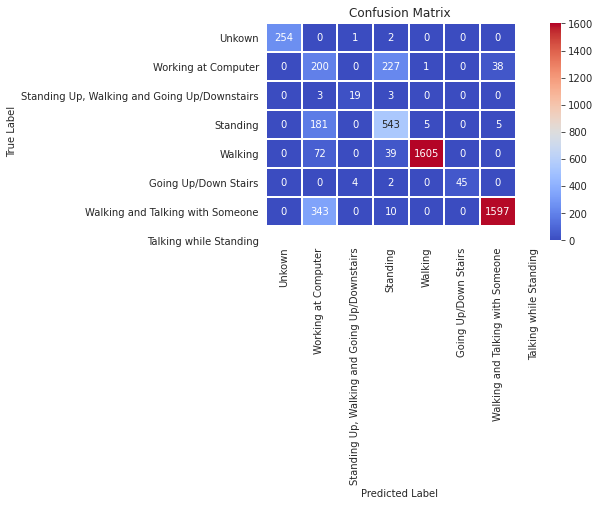

                                              precision    recall  f1-score   support

                        Going Up/Down Stairs       1.00      0.99      0.99       257
                                    Standing       0.25      0.43      0.32       466
Standing Up, Walking and Going Up/Downstairs       0.79      0.76      0.78        25
                      Talking while Standing       0.66      0.74      0.70       734
                                     Walking       1.00      0.94      0.96      1716
            Walking and Talking with Someone       1.00      0.88      0.94        51
                         Working at Computer       0.97      0.82      0.89      1950

                                    accuracy                           0.82      5199
                                   macro avg       0.81      0.79      0.80      5199
                                weighted avg       0.87      0.82      0.84      5199



In [58]:
from sklearn import metrics
from sklearn.metrics import classification_report


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=activities,
                yticklabels=activities,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

show_confusion_matrix(y_test, gb_clf_grid.predict(X_test))

print(classification_report(y_test, gb_clf_grid.predict(X_test)))

# **E. Conclusion and Recommendations**

In this notebook we tried to predict physical activities from the accelerometer data. The major challenges/steps we had are as follows:

1. The subjects'/users' behavior is different from one another. With this in mind, I believe that it was necessary (as I did) to use a subject-based split of the training and test data. Although not shown here, I found that if we perform random selection of samples (mixing all users) the resulting test scores would be high. However, the model would perform poorly on data from subjects not seen before. Again, this is because of significant differences between subjects.

2. Because the subjects did not perform the assigned activities continuously for the entire period or they did some other activities during their assigned avtivities, it was necessary to filter the data to remove periods that would be otherwise mislabeled. To that end, I divided the raw data into one-second windows, each with 52 observations. I assigned a sample number to each 52 consecutive observations. I then calculated the standard deviation of the sensor data for each of the samples and then follow the interquartile approach to filter data. I believe removing outlier is an important stept in the problem as it can significantly affect the performance of any machine learning algorithm. 

3. It was indicated that the number of activities in the dataset is not balanced. We found that "Talking while standing" and "Working at Computer" are dominant in our dataset. This can lead to models not capable of predicting less observed activities.  Therefore, I would like to incorporate other public datasets to create a more robust model with more subjects and balanced number of activities.

4. Creatining relevant features is generally a very challenging task. Ideally, it requires some domain knowledge. In this notebook, we tried to create some basic features that could help us predict activities from the accelerometer data. Initially, we introduced many feature, but having many features is not always helpful as it can lead to the over fitting problem. Therefore, we examined the correlation between features and also employed randon forest analysis in order to identify a subset of importatnt features that are independent from one another. 

5. Finally, we trained and tested several algorithms. Unfortunately, they suffer from the over fitting problem. They perform well on the training data, but poorly on the test data. One way to overcome this problem is to collect more data. Additionally, introducing more informative features can hep us reduce the overfitting problem. Anyhow, it seems that in our case GradientBoostingClassifier and XGBClassifier outperform other algorithms in the sense that they suffer less from over fitting problem. 


As a future work, I would recommend exploring this problem using neural networks (NNs). Unlike the classical approach that we followed in this notebook which required extensive data cleaning and feature engineering, NNs can model the raw data directly. Three types of neural network architectures that might be appropriate are:

1. Convolutional Neural Networks or CNNs.
2. Recurrent Neural Networks or RNNs, specifically Long Short-Term Memory or LSTMs.
3. CNN LSTMs.

CNNs are able to extract features from input sequences, such as windows of input accelerometer data. RNNs, such as LSTMs are able to learn from long sequences of input data directly, and learn long-term relationships in the data. One-dimensional CNNs have been widely used for this type of problem, with one channel for each axis of the accelerometer data. A good simple starting point would be to fit a CNN model on windows of sequence data directly.

# Thank You for Reviewing this Work :)